In [1]:
import numpy as np
import pandas as pd
import scipy.signal as sgnl
from pywt import wavedec
from matplotlib import pyplot as plt
import matplotlib.lines as lines
from mpl_toolkits import mplot3d as plt3d
from scipy.stats import entropy

In [2]:
%matplotlib notebook
plt.style.use('seaborn-whitegrid')

In [3]:
def window_entropy(data, winwidth):
    data = data - np.min(data)
    datalen = len(data)
    #data = np.round(data, decimals=2)

    halfwidth = int(winwidth / 2)
    entropies = np.array([], dtype=np.float32)
    #entropies = np.append(entropies, [0 for x in range(halfwidth)])

    for sample in np.arange(0, datalen):
        if sample % 10000 == 0:
            print('Sample:', sample)
            
        if sample < halfwidth:
            low_border = sample
            up_border = sample + halfwidth
        elif sample > datalen - halfwidth:
            low_border = sample - halfwidth
            up_border = datalen 
        else:
            low_border = sample - halfwidth
            up_border = sample + halfwidth
            
        local_data = data[low_border:up_border]
        values, counts = np.unique(local_data, return_counts=True)
        props = counts / (winwidth + 1)
        entropies = np.append(entropies, entropy(counts))

    #entropies = np.append(entropies, [0 for x in range(halfwidth)])
    return entropies

def window_mean(data, winwidth, verbose_iter=10000):
    #data = data - np.min(data)
    datalen = len(data)
    #data = np.round(data, decimals=2)

    halfwidth = int(winwidth / 2)
    data_new = np.array([], dtype=np.float32)

    for sample in np.arange(0, datalen):
        if sample % verbose_iter == 0:
            print('Sample:', sample)
        if sample < halfwidth:
            low_border = sample
            up_border = sample + halfwidth
        elif sample > datalen - halfwidth:
            low_border = sample - halfwidth
            up_border = datalen 
        else:
            low_border = sample - halfwidth
            up_border = sample + halfwidth
            
        local_data = data[low_border:up_border]
        data_new = np.append(data_new, np.mean(local_data))

    return data_new

def undersample(data, reducecoef=2):
    data = np.array(data)
    new_data = np.array([], dtype=np.float32)
    for sample in np.arange(0, len(data), reducecoef):
        #if sample % 1000 == 0:
        #    print('Sampling...', sample)
        new_data = np.append(new_data, data[sample])
    return new_data

def plot_cwt_map(coefs, cursubplot=111, cmap='viridis'):
    x, y = coefs.shape
    x = range(x)
    y = range(y)
    X, Y = np.meshgrid(x, y)

    hfig = plt.figure()
    ha = hfig.add_subplot(cursubplot, projection='3d')
    ha.plot_surface(X, Y, np.transpose(coefs), cmap=cmap)
    
def mean_quadratic(signal, wind_width=10):
    new_signal = []
    for sample in range(len(signal)-1):
        subarray = []
        for index in range(wind_width):
            subarray.append((abs(signal[sample-index+1] - signal[sample-index])**2)
                           * (wind_width-index+1))
        new_signal.append(sum(subarray))
    return new_signal

2 - полных обструкций нет. 3 - есть, частично. 5 - ужасная разметка.

## Load files

In [4]:
record = '1'
path_file = 'C:/Users/Gagampy/YandexDisk/Nauch_Rabota/Spiro/Database_csv/Undersampled/'
spo_ = np.array(pd.read_csv(path_file + 'spo_{}.csv'.format(record), header=0))[:,1]
spiro = np.array(pd.read_csv(path_file + 'spiro_{}.csv'.format(record), header=0))[:,1]

In [5]:
path_segments = 'C:/Users/Gagampy/YandexDisk/YandexDisk/Nauch_Rabota/Spiro/Database_csv/Segments/{}/'.format(record)
spiro_ends = np.array(pd.read_csv(path_segments + 'spiro_end.csv', header=0))
spiro_begs = np.array(pd.read_csv(path_segments + 'spiro_beg.csv', header=0))

spo_ends = np.array(pd.read_csv(path_segments + 'spo_end.csv', header=0))
spo_begs = np.array(pd.read_csv(path_segments + 'spo_beg.csv', header=0))

In [6]:
def undersample_segment_idxs(segment_indexes, undersample_coef=20):
    segment_indexes_new = segment_indexes / 20
    return segment_indexes_new.astype(int)
    
spiro_begs = undersample_segment_idxs(spiro_begs)
spiro_ends = undersample_segment_idxs(spiro_ends)
spo_begs = undersample_segment_idxs(spo_begs)
spo_ends = undersample_segment_idxs(spo_ends)

<IPython.core.display.Javascript object>


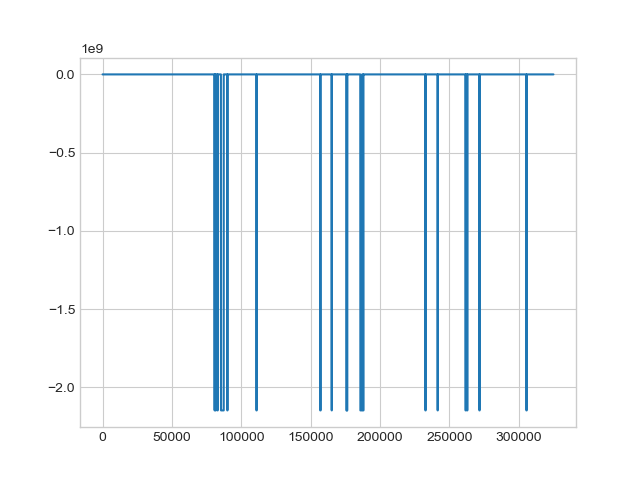

In [7]:
plt.figure()
plt.plot(spo_)
#plt.scatter(spiro_begs, spiro[spiro_begs], c='r')
#plt.scatter(spiro_ends, spiro[spiro_ends], c='k')

<IPython.core.display.Javascript object>


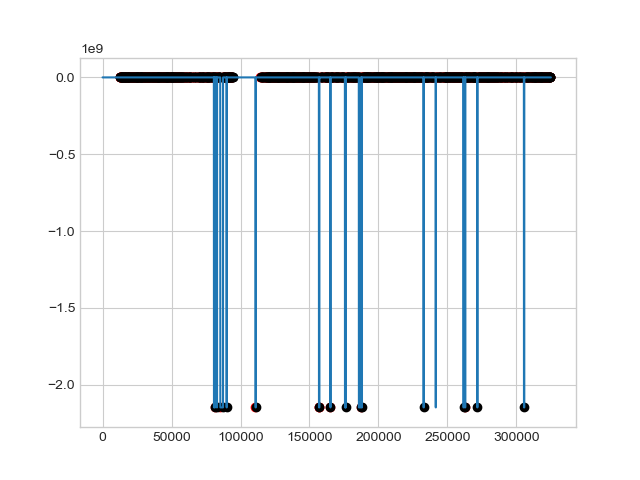

In [8]:
plt.figure()
plt.plot(spo_)
plt.scatter(spo_begs, spo_[spo_begs], c='r')
plt.scatter(spo_ends, spo_[spo_ends], c='k')

### Delete SPO amplitude artifacts 

In [9]:
def delete_artf(spo):
    newshape = (spo.shape[0],) 
    spo = np.reshape(spo, newshape=newshape)
    #sig_std = np.std(spo)
    #sig_mean = np.mean(spo)

    wrong_idxs = np.where(spo < -1e9)[0]
    spo[wrong_idxs] = np.median(spo)
    return spo

spo = delete_artf(spo_)

<IPython.core.display.Javascript object>


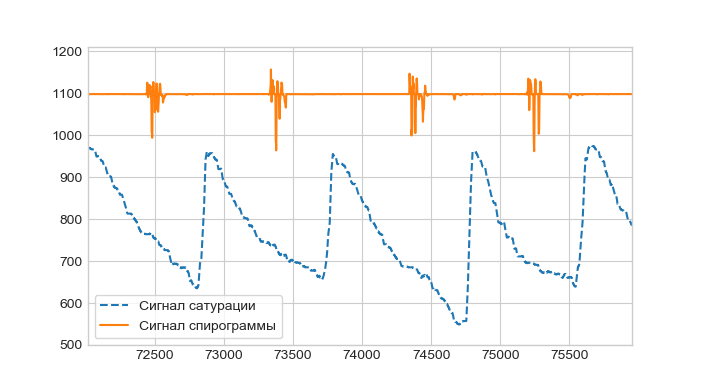

In [26]:
f = plt.figure()
ax = plt.axes()
ax.plot(spo, linestyle='--', label='Сигнал сатурации')
ax.plot(spiro/50 + 1100, label='Сигнал спирограммы')
ax.legend(frameon=True, fancybox=True, facecolor ='w')

### Plot SPO D4 coeffs

<IPython.core.display.Javascript object>


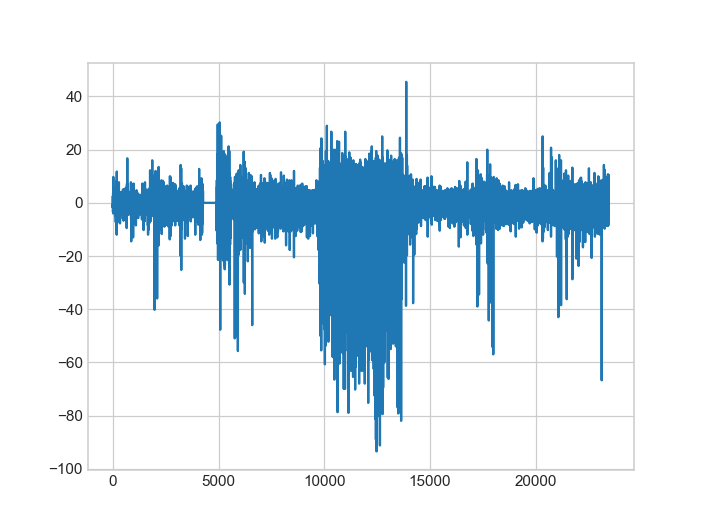

In [197]:
coeffs_spo = wavedec(spo, 'db1', level=4)
cA4_spo, cD4_spo, cD3_spo, cD2_spo, cD1_spo = coeffs_spo
cD4_spo_2 = cD4_spo
plt.figure()
plt.plot(cD4_spo_2)

In [198]:
#cD4_spo_peaks_real = np.array(cD4_spo_peaks) * 16
freq_spo_real = freq_spo * 16
freq_spo_real
spo_wmean = window_mean(spo, winwidth=100, verbose_iter=5e4)

Sample: 0
Sample: 50000
Sample: 100000
Sample: 150000
Sample: 200000
Sample: 250000
Sample: 300000
Sample: 350000


In [200]:
def find_spo_detail_coefs_peaks(signal, width=60, threshold_coef=0.07, blindzone=10):
    
    peak_pretendents = np.array([], dtype=np.int64)
    peaks_xcoord = np.array([])
    len_signal = len(signal)
    threshold = max(signal) * threshold_coef
    blindzone_count = blindzone
    
    for sample in range(0, len_signal):
        if sample >= len_signal:
            break
            
        blindzone_count += 1
        if sample + width > len_signal:
            upper_limit = len_signal 
        else:
            upper_limit = sample + width

        if signal[sample] > threshold and blindzone_count > blindzone:
            for sample_in_wind in range(sample,upper_limit):
                if signal[sample_in_wind] == np.max(signal[sample_in_wind-3:sample_in_wind+3]):
                    peak_pretendents = np.append(peak_pretendents, sample_in_wind)
                    break
            blindzone_count = 0
                
        peak_pretendents = np.unique(peak_pretendents)
        # Evaluate mean freq of peaks
        freq_array = np.array([], dtype=np.int16)
        for elem_indx in range(len(peak_pretendents)-1):
            freq_array = np.append(
                freq_array, peak_pretendents[elem_indx] - peak_pretendents[elem_indx+1])
        if freq_array.size != 0:
            freq_mean = abs(int(np.mean(freq_array, axis=0)))
        else:
            freq_mean = np.nan
        peaks_xcoord = np.unique(np.sort(np.concatenate([peaks_xcoord, peak_pretendents])))

    peaks_xcoord = list(map(int, peaks_xcoord))
    return peaks_xcoord, freq_mean


cD4_spo_abs = abs(cD4_spo_2)
# 7 - 40, 0.1, 20
# 4 - 60, 0.15, 20
# 8 - 60, 0.2, 20
cD4_spo_peaks, freq_spo = find_spo_detail_coefs_peaks(cD4_spo_abs, width=60, threshold_coef=0.2, blindzone=20)

<IPython.core.display.Javascript object>


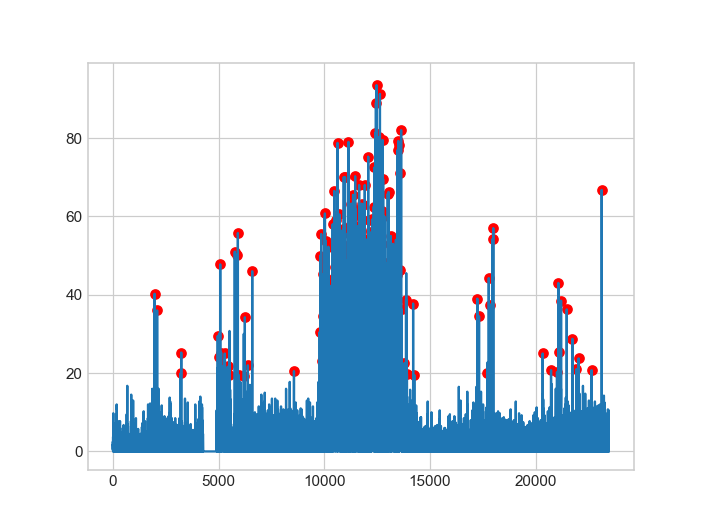

In [201]:
plt.figure()
plt.plot(cD4_spo_abs)
plt.scatter(cD4_spo_peaks, cD4_spo_abs[cD4_spo_peaks], c='r')

<IPython.core.display.Javascript object>


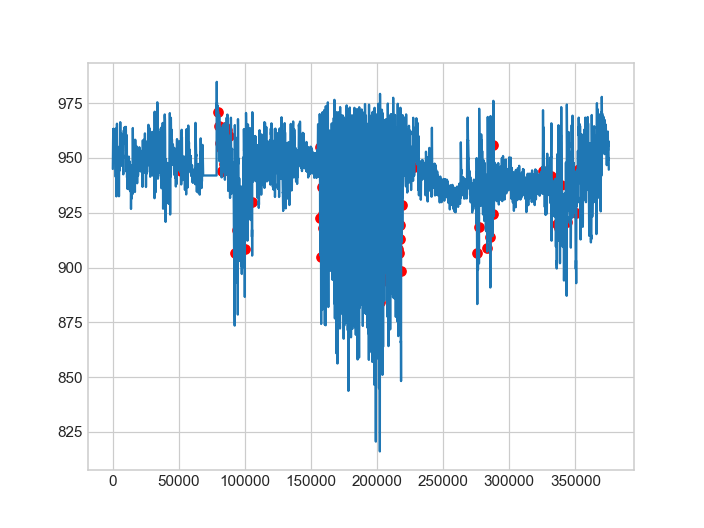

In [202]:
cD4_spo_peaks16 = np.array(cD4_spo_peaks) * 16
plt.figure()
plt.plot(spo_wmean)
plt.scatter(cD4_spo_peaks16, spo_wmean[cD4_spo_peaks16], c='r')

In [203]:
def find_mins_spo(spo, initial_points, freq, wind_width=100):
    x_spo_cycle_min = np.array([], dtype=np.int16)
    sign_len = len(spo)
    up_limit = int(freq * 1.5)
    for point in initial_points:
        upper_bound = point + wind_width
        lower_bound = point - wind_width
        if upper_bound > sign_len:
            sampling_area = np.arange(lower_bound, sign_len)   
        else:
            sampling_area = np.arange(lower_bound, upper_bound)

        for sample in sampling_area:
            try:
                if spo_wmean[sample] == min(spo_wmean[sampling_area]):
                    x_spo_cycle_min = np.append(x_spo_cycle_min, sample)
                    break
            except:
                break
    return x_spo_cycle_min

In [204]:
spo_mins = find_mins_spo(spo_wmean, cD4_spo_peaks16, freq_spo_real, wind_width=100)

In [205]:
def find_spo_maxs(spo, min_points, freq, wind_width=200):
    maxpeaks_spo = []
    #wind_width = int(freq_spo_real/4)
    len_spo = len(spo)
    for point in min_points:
        lower_bound = point - wind_width
        if lower_bound < 0:
            lower_bound = 0
        # print(lower_bound, point)
        sampling_area = np.arange(lower_bound, point)
        max_coord = np.argmax(spo[sampling_area])
        if max_coord:
            maxpeaks_spo.append(lower_bound+max_coord)
    return np.unique(maxpeaks_spo)


In [206]:
spo_maxs = find_spo_maxs(spo_wmean, spo_mins, freq_spo_real, wind_width=700) 
# 1 - 1200, 4 - 1000, 6 - 3000, 7 - 600, 8 - 700

<IPython.core.display.Javascript object>


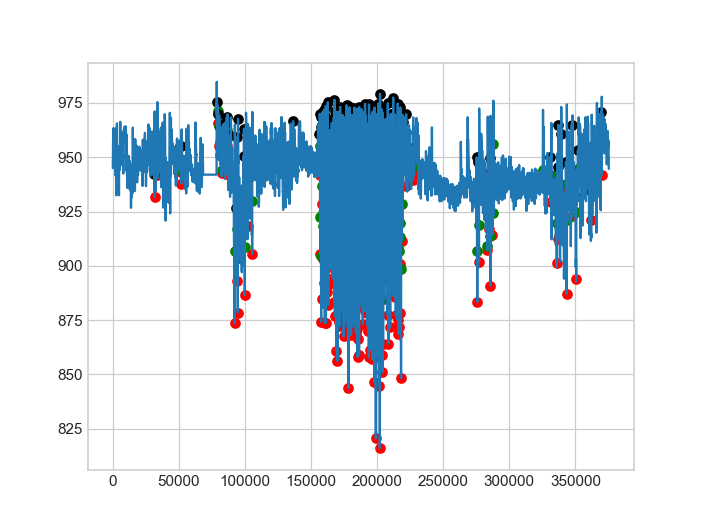

In [207]:
plt.figure()
plt.plot(spo_wmean)
plt.scatter(spo_mins, spo_wmean[spo_mins], c='r')
plt.scatter(cD4_spo_peaks16, spo_wmean[cD4_spo_peaks16], c='g')
plt.scatter(spo_maxs, spo_wmean[spo_maxs], c='k')

In [208]:
len(spo_mins), len(spo_maxs)

(176, 150)

In [209]:
len_maxs = len(spo_maxs)
spo_mins_ = []
spo_maxs_ = []
for max_idx, cur_max in enumerate(spo_maxs):
    if max_idx == len_maxs-1:
        break
    cur_min = np.where((spo_mins > cur_max) & (spo_mins < spo_maxs[max_idx+1]))[0]
    if cur_min.shape[0] != 0:
        spo_mins_.append(spo_mins[cur_min[0]])
        spo_maxs_.append(cur_max)

In [210]:
len(spo_mins_), len(spo_maxs_), len(spiro_begs), len(spiro_ends)

(149, 149, 308, 308)

In [211]:
def get_spiro_peak_coord(spiro, spiro_begs, spiro_ends, operation):
    peak_coords = []
    if operation == 'max':
        oper = np.argmax
    elif operation == 'min':
        oper = np.argmin
    else:
        raise ValueError
        
    for spiro_end in spiro_ends:
        next_beginings = np.where(spiro_begs > spiro_end)[0]
        if next_beginings.shape[0] != 0:
            next_begining_index = next_beginings[0]
            spiro_begining = spiro_begs[next_begining_index][0]
            spiro_end = spiro_end[0]
            peak_coords.append(oper(spiro[spiro_end:spiro_begining]) + spiro_end)
    return peak_coords

spiro_peak_coords = get_spiro_peak_coord(spiro, spiro_begs, spiro_ends, 'max')
spiro_min_coords = get_spiro_peak_coord(spiro, spiro_begs, spiro_ends, 'min')

<IPython.core.display.Javascript object>


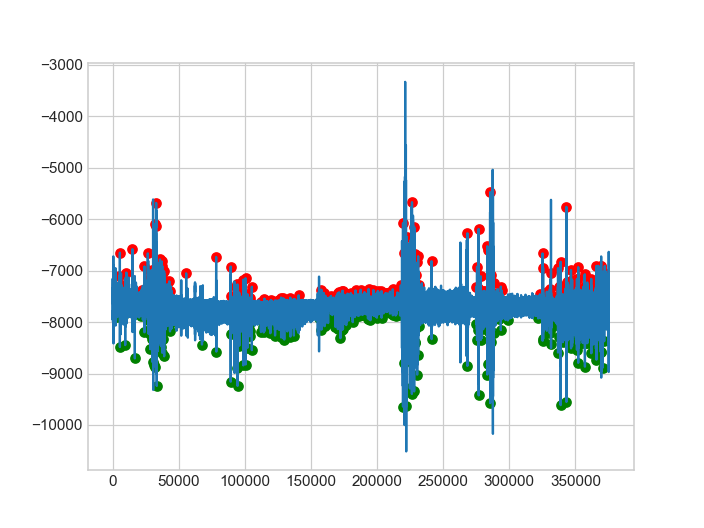

In [212]:
plt.figure()
plt.plot(spiro)
plt.scatter(spiro_peak_coords, spiro[spiro_peak_coords], c='r')
plt.scatter(spiro_min_coords, spiro[spiro_min_coords], c='g')

In [213]:
def create_feature_list(spo, spiro, spo_mins, spo_maxs, 
                        spiro_ends, spiro_begs, spiro_peak_coords,
                       spiro_min_coords):
    feature_list = []
    prev_spo_max = None
    prev_spo_min = None
    for spiro_current_index, spiro_beg in enumerate(spiro_begs):
        if spiro_current_index == len(spiro_begs)-1:
            break
        #print(spiro_beg, spiro_ends[spiro_current_index])
        next_spo_beginings = np.where((spo_maxs >= spiro_beg) 
                                      & (spo_maxs <= spiro_ends[spiro_current_index]))[0]
        prev_spiro_peaks = np.where((spiro_peak_coords <= spiro_beg) 
                                    & (spiro_peak_coords >= spiro_ends[spiro_current_index-1]))[0]
        prev_spiro_mins = np.where((spiro_min_coords <= spiro_beg) 
                                    & (spiro_min_coords >= spiro_ends[spiro_current_index-1]))[0]
        
        print(next_spo_beginings, prev_spiro_peaks)
        if next_spo_beginings.shape[0] != 0 and prev_spiro_peaks.shape[0] != 0 and prev_spiro_mins.shape[0] != 0:
            next_spo_index = next_spo_beginings[0]
            next_spo_max = spo_maxs[next_spo_index]
            next_spo_min = spo_mins[next_spo_index]
            if next_spo_max == prev_spo_max or next_spo_min == prev_spo_min:
                continue
                
            prev_spiro_peak_index = prev_spiro_peaks[-1]
            prev_spiro_min_index = prev_spiro_mins[-1]
            
            prev_spiro_peak = spiro_peak_coords[prev_spiro_peak_index]
            prev_spiro_min = spiro_min_coords[prev_spiro_min_index]
            
            prev_spiro_peak_ampl = spiro[prev_spiro_peak]
            prev_spiro_min_ampl = spiro[prev_spiro_min]
            
            prev_spo_max = next_spo_max
            prev_spo_min = next_spo_min
            
            spiro_end = spiro_ends[spiro_current_index]
            obstruction_len = spiro_end - spiro_beg
            spo_amplitude_diff = spo[next_spo_max] - spo[next_spo_min]
            
            feature_list.append((spiro_beg[0], spiro_end[0], obstruction_len[0], 
                                 next_spo_max, next_spo_min, spo_amplitude_diff, 
                                 prev_spiro_peak_ampl, prev_spiro_min_ampl,
                                 prev_spiro_peak, prev_spiro_min))
    return feature_list

In [214]:
feature_list = create_feature_list(spo_wmean, spiro, spo_mins_, 
                                   spo_maxs_, spiro_ends, spiro_begs, 
                                   spiro_peak_coords, spiro_min_coords)

[] []
[] [0]
[] [1]
[] [2]
[] [3]
[] [4]
[] [5]
[] [6]
[] [7]
[] [8]
[] [9]
[] [10]
[] [11]
[] [12]
[] [13]
[] [14]
[] [15]
[] [16]
[] [17]
[] []
[] [19]
[] [20]
[] [21]
[] [22]
[] [23]
[] [24]
[] [25]
[] [26]
[] [27]
[] [28]
[] [29]
[] [30]
[] [31]
[] [32]
[] [33]
[] [34]
[] [35]
[] [36]
[] [37]
[12] [38]
[13] [39]
[14] [40]
[] [41]
[] [42]
[] [43]
[] [44]
[] [45]
[] [46]
[] [47]
[] [48]
[] [49]
[] [50]
[] [51]
[] [52]
[] [53]
[] [54]
[17] [55]
[] [56]
[] [57]
[] [58]
[] [59]
[] [60]
[] [61]
[] [62]
[] [63]
[] [64]
[] [65]
[] [66]
[] [67]
[] [68]
[] [69]
[] [70]
[] [71]
[] [72]
[] [73]
[19] [74]
[20] [75]
[] [76]
[] [77]
[22] [78]
[23] [79]
[24] [80]
[25] [81]
[26] [82]
[27] [83]
[28] [84]
[] [85]
[] [86]
[30] [87]
[31] [88]
[32] [89]
[] [90]
[33] [91]
[34] [92]
[35] [93]
[] [94]
[36] [95]
[] [96]
[37] [97]
[] [98]
[38] [99]
[39] [100]
[40] [101]
[41] [102]
[42] [103]
[43] [104]
[44] [105]
[45] [106]
[46] [107]
[47] [108]
[48] [109]
[] [110]
[] [111]
[49] [112]
[50] [113]
[51] [114]
[

In [215]:
def find_none(points):
    return not sum(np.isnan(points))

cleared_features = list(filter(find_none, feature_list))

In [216]:
len(cleared_features[0])

10

In [217]:
features_df = pd.DataFrame(cleared_features)
features_df.columns = ['Spiro_iBeg', 'Spiro_iEnd',
                      'Spiro_obstr_len', 'Spo_iMax', 'Spo_iMin', 
                       'Spo_decr', 'Spiro_peak_ampl', 'Spiro_min_ampl',
                      'Prev_spiro_peak_coord', 'Prev_spiro_min_coord']
features_df.tail()

,Spiro_iBeg,Spiro_iEnd,Spiro_obstr_len,Spo_iMax,Spo_iMin,Spo_decr,Spiro_peak_ampl,Spiro_min_ampl,Prev_spiro_peak_coord,Prev_spiro_min_coord
119,342615,343045,430,342782,343334,60.84,-7351.7,-8358.4,342351,342361
120,347025,347295,270,347141,347661,42.18,-6988.9,-8511.5,346587,346645
121,349930,350165,235,349940,350572,38.40,-7524.1,-8137.1,349838,349852
122,351800,351995,195,351849,352347,14.31,-7158.4,-8304.5,351431,351476
123,361245,361745,500,361524,362130,13.65,-7390.4,-8305.3,360537,360309


In [218]:
features_df.head()

,Spiro_iBeg,Spiro_iEnd,Spiro_obstr_len,Spo_iMax,Spo_iMin,Spo_decr,Spiro_peak_ampl,Spiro_min_ampl,Prev_spiro_peak_coord,Prev_spiro_min_coord
0,93275,93540,265,93485,93872,33.43,-7659.4,-7890.2,93078,93107
1,93930,94270,340,93988,94573,80.71,-7311.4,-8901.5,93561,93642
2,94565,95045,480,94693,95315,64.00,-7268.6,-9241.3,94306,94379
3,104725,105090,365,104991,105422,46.13,-7646.7,-7952.4,104562,104483
4,154925,156355,1430,155768,156380,18.62,-7479.3,-8262.6,140559,136989


In [219]:
features_df.loc[features_df.Spiro_iEnd < features_df.Spiro_iBeg]

,Spiro_iBeg,Spiro_iEnd,Spiro_obstr_len,Spo_iMax,Spo_iMin,Spo_decr,Spiro_peak_ampl,Spiro_min_ampl,Prev_spiro_peak_coord,Prev_spiro_min_coord


In [220]:
features_df.to_csv('C:/Users/Gagampy/YandexDisk/YandexDisk/Nauch_Rabota/Spiro/Database_csv/Record_{}_features/features_df.csv'.format(record), index=False)

In [ ]:
x_spo_cycle_min = np.array([], dtype=np.int16)
window_width = 200
sign_len = len(spo_wmean)
up_limit = int(freq_spo_real * 1.5)
for point in cD4_spo_peaks_real:
    if point + window_width > sign_len:
        sampling_area = np.arange(point, sign_len)
    elif point + freq_spo_real > sign_len:
        sampling_area = np.arange(point+window_width, sign_len)   
    else:
        sampling_area = np.arange(point+window_width, point + up_limit)
    for sample in sampling_area:
        if sample + window_width >= sign_len:
            up_limit_inner = sign_len - 1
        else:
            up_limit_inner = sample + window_width
            
        try:
            if spo_wmean[sample] == min(spo_wmean[sample-window_width:up_limit_inner]):
                x_spo_cycle_min = np.append(x_spo_cycle_min, sample)
                break
        except:
            break

In [102]:
maxpeaks_spo = []
wind_width = int(freq_spo_real/4)
len_area = len(spo_wmean)
for point in x_spo_cycle_min:
    searching_limit = int(point - freq_spo_real*2)
    if searching_limit < 0:
        searching_limit = 0
        
    for sample in np.arange(point, searching_limit, -1):
        if searching_limit == 0:
            low_border = 0
            up_border = sample + wind_width
        else:
            if sample - wind_width < 0:
                low_border = 0
                up_border = sample + wind_width
            elif sample + wind_width >= len_area:
                low_border = sample - wind_width
                up_border = len_area
            elif sample - wind_width < 0 and sample + wind_width > len_area:
                low_border = 0
                up_border = len_area
            else:
                low_border = sample - wind_width
                up_border = sample + wind_width
                
        if spo_wmean[sample] == max(spo_wmean[low_border:up_border]):
            maxpeaks_spo.append(sample)
            break
            
maxpeaks_spo = np.unique(maxpeaks_spo)